In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings("ignore")

import lime
import lime.lime_tabular

import pickle
from xgboost import XGBClassifier

from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
          ConfusionMatrixDisplay, confusion_matrix, classification_report, 
          accuracy_score,precision_score,recall_score,roc_auc_score,roc_curve,f1_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


In [3]:
print(sys.executable)


d:\SWS\envs\ME\python.exe


In [4]:
# Read the dataset
df = pd.read_csv('../dataset/data.csv')
df.head()


Age Gender Smoking Hx Smoking Hx Radiothreapy Thyroid Function  \
0   27      F      No         No              No        Euthyroid   
1   34      F      No        Yes              No        Euthyroid   
2   30      F      No         No              No        Euthyroid   
3   62      F      No         No              No        Euthyroid   
4   62      F      No         No              No        Euthyroid   

          Physical Examination Adenopathy       Pathology     Focality Risk  \
0   Single nodular goiter-left         No  Micropapillary    Uni-Focal  Low   
1          Multinodular goiter         No  Micropapillary    Uni-Focal  Low   
2  Single nodular goiter-right         No  Micropapillary    Uni-Focal  Low   
3  Single nodular goiter-right         No  Micropapillary    Uni-Focal  Low   
4          Multinodular goiter         No  Micropapillary  Multi-Focal  Low   

     T   N   M Stage       Response Recurred  
0  T1a  N0  M0     I  Indeterminate       No  
1  T1a  N0  M0     I      Excellent       No  
2  T1a  N0  M0     I      Excellent       No  
3  T1a  N0  M0     I      Excellent       No  
4  T1a  N0  M0     I      Excellent       No

In [5]:
df.shape


(383, 17)

In [6]:
df.columns


Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred'],
      dtype='object')

In [7]:
df.dtypes


Age                      int64
Gender                  object
Smoking                 object
Hx Smoking              object
Hx Radiothreapy         object
Thyroid Function        object
Physical Examination    object
Adenopathy              object
Pathology               object
Focality                object
Risk                    object
T                       object
N                       object
M                       object
Stage                   object
Response                object
Recurred                object
dtype: object

# Data Preprocessing
## EDA(Exploratory Data Analysis)

In [8]:
profile = ProfileReport(df)
profile.to_file(output_file='../output/graph/data_profile.html')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:00<00:00, 39.69it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [292]:
def plot_data_graph(data_label):
      plt.figure(figsize=(9, 7))
      if pd.api.types.is_numeric_dtype(df[data_label]) and df[data_label].nunique() > 10:
        sns.histplot(data=df, x=data_label, bins=25, kde=True, color='skyblue')
      else:
        sns.countplot(x=data_label, data=df, palette='pastel', width=0.5)

      if ((df[data_label].astype(str).apply(len) > 15).any()):
         plt.xticks(rotation=30)

      plt.title(f'Count of {data_label}')
      plt.xlabel(data_label)
      plt.ylabel('Count')
      plt.show()


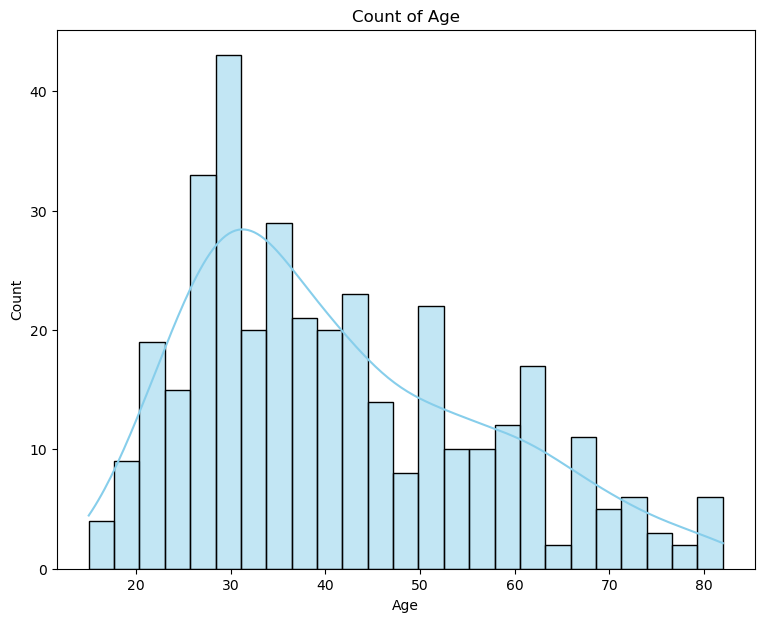

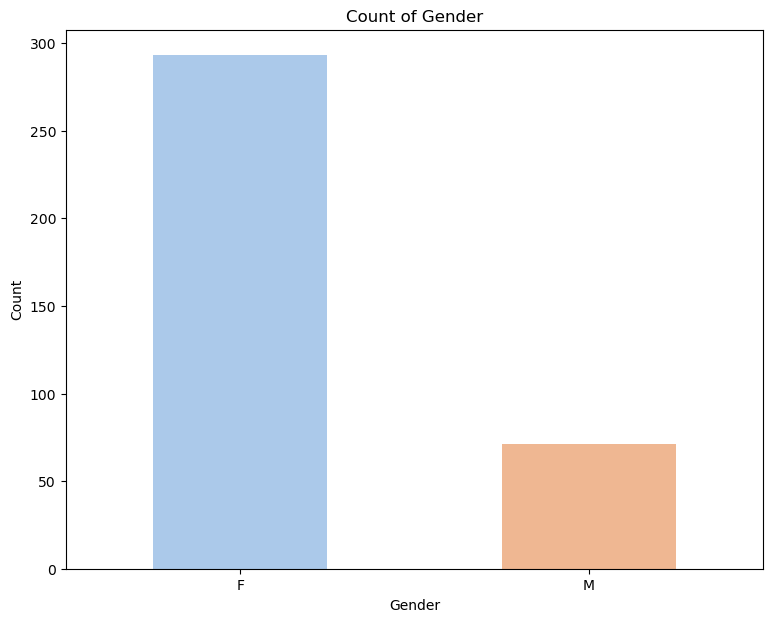

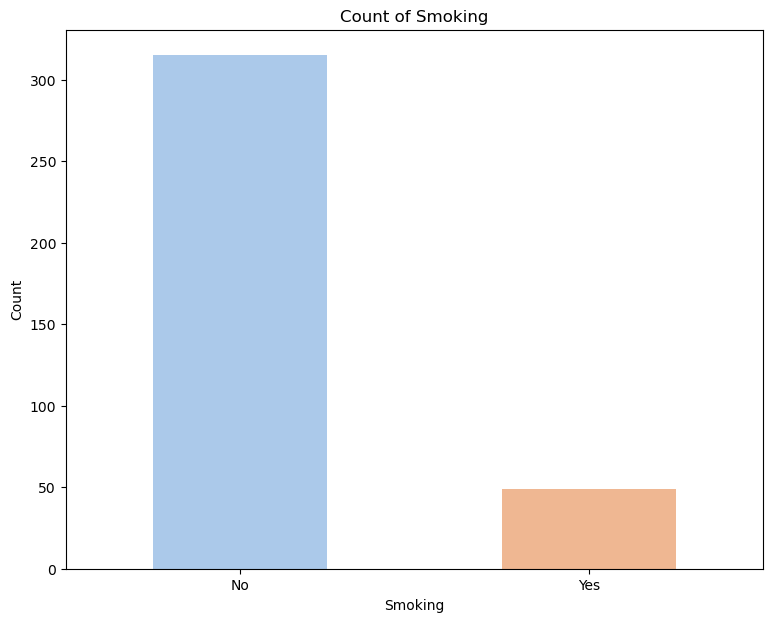

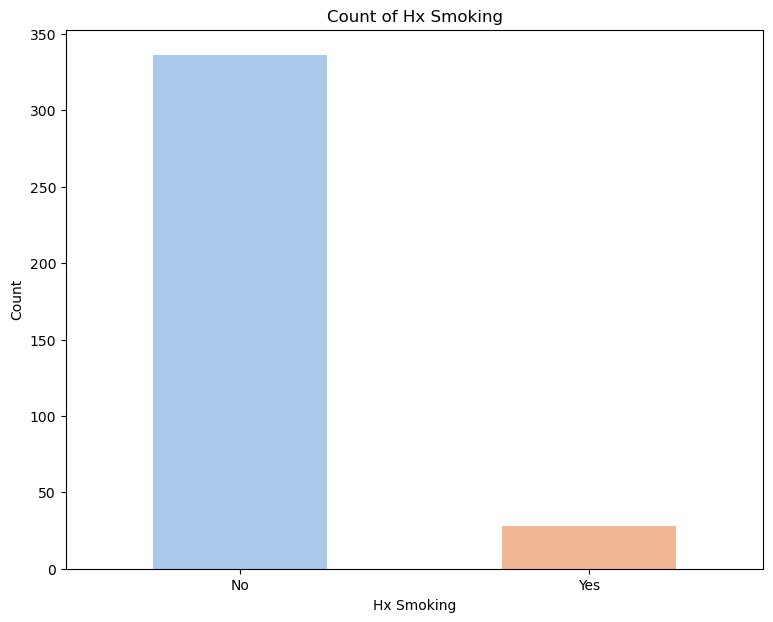

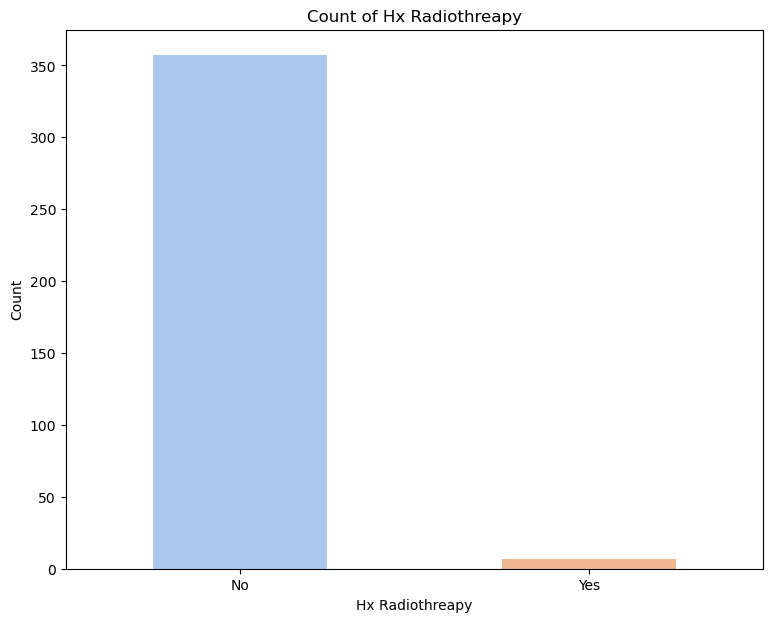

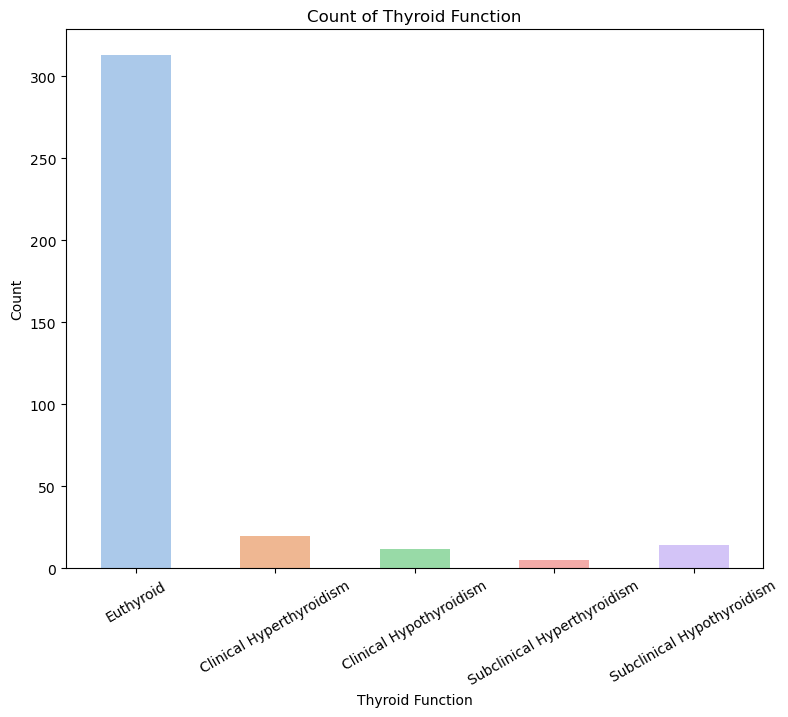

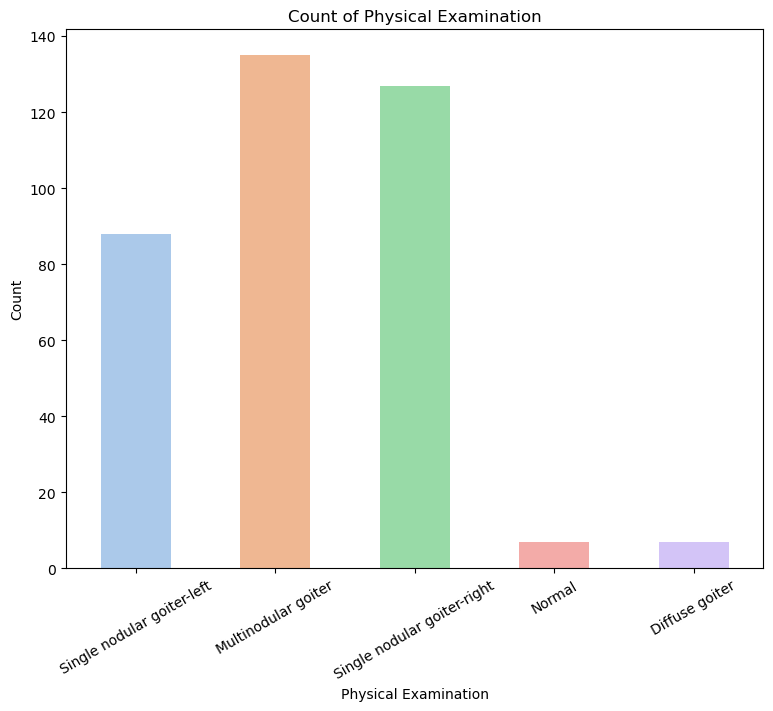

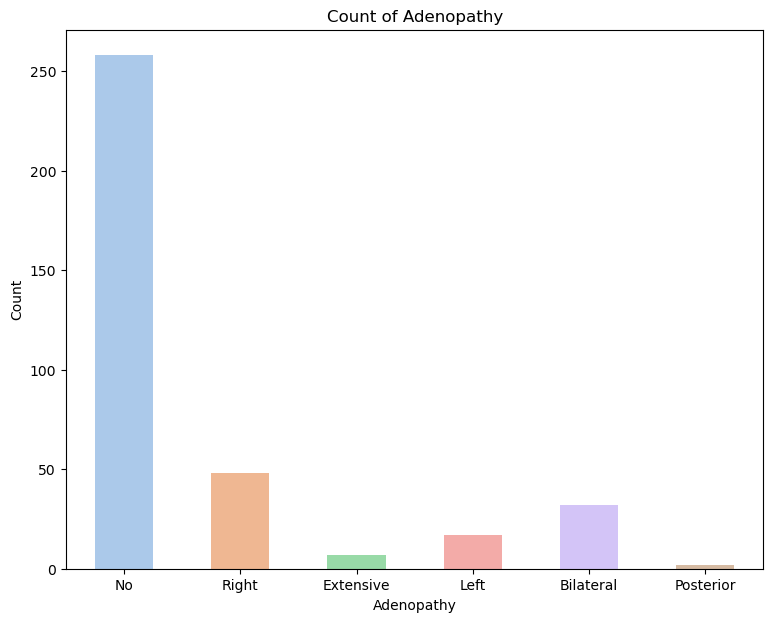

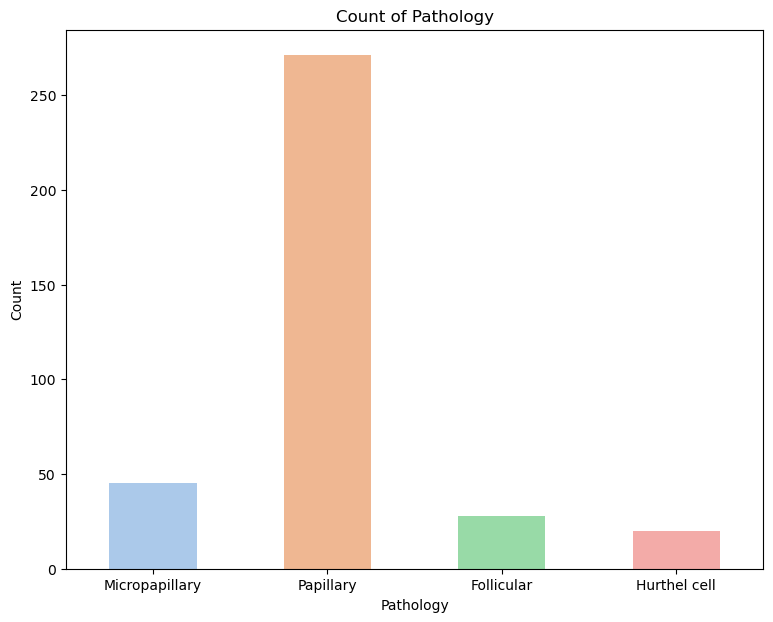

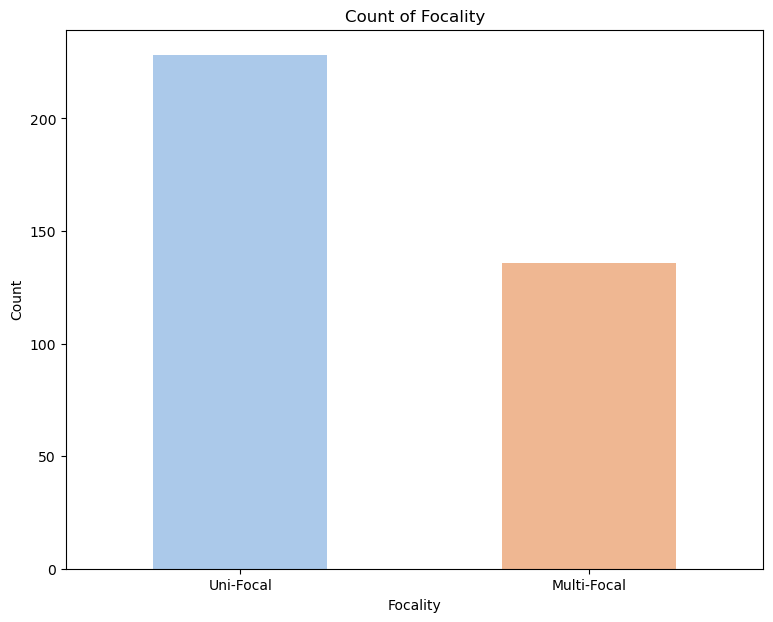

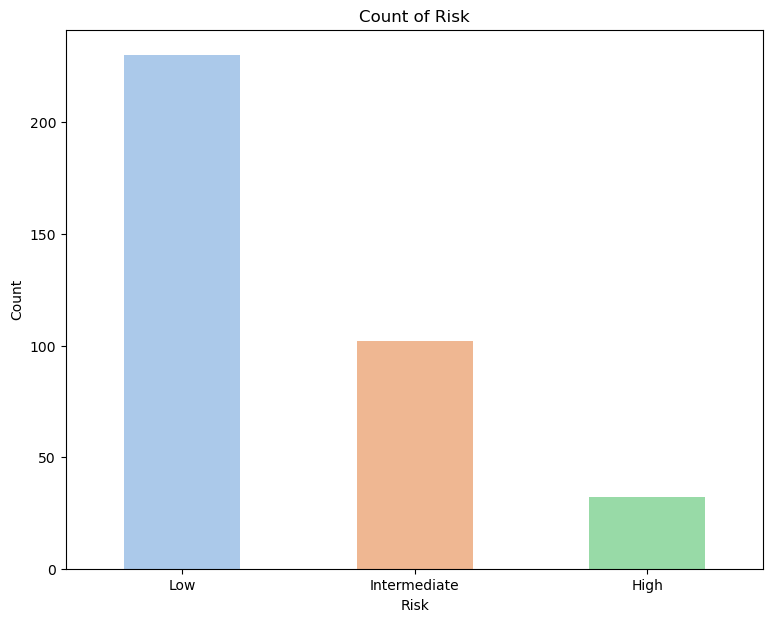

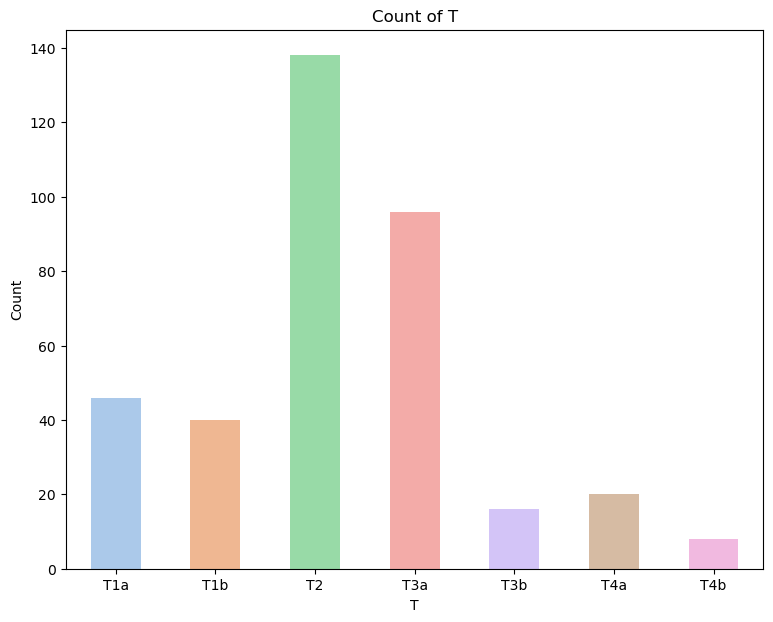

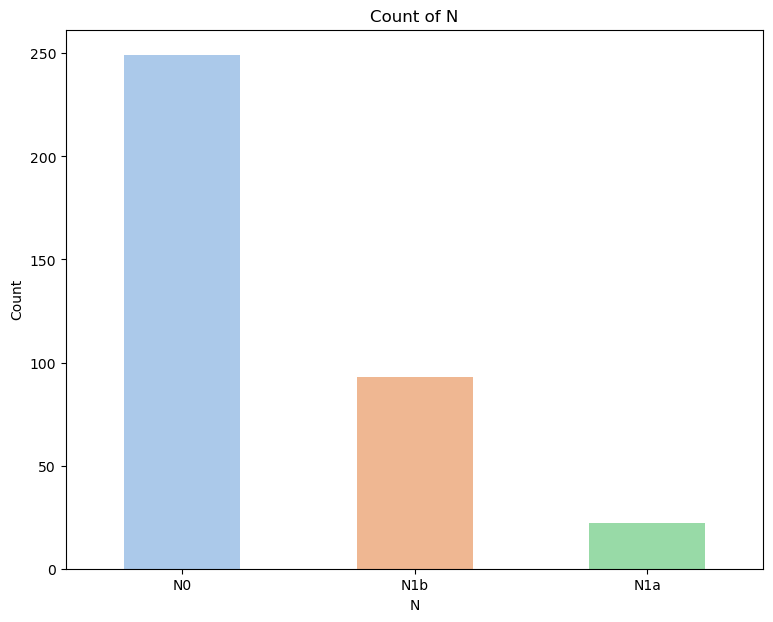

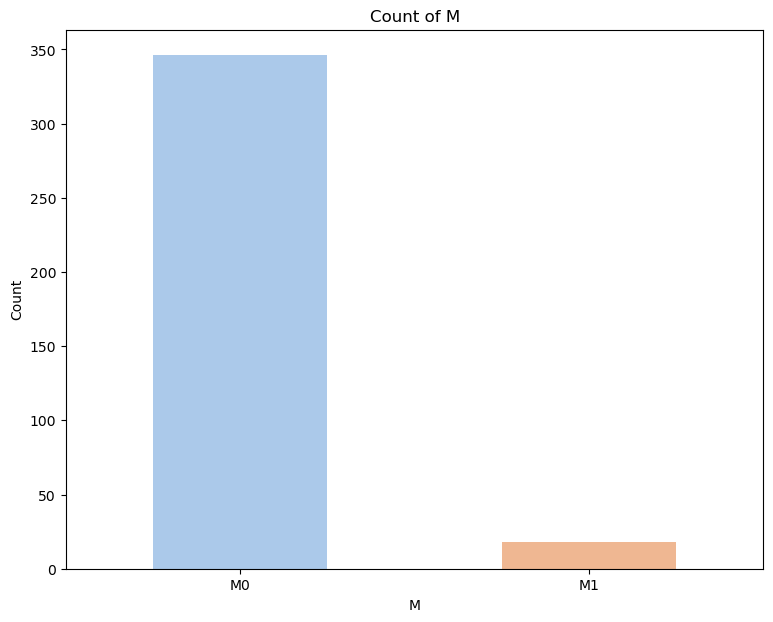

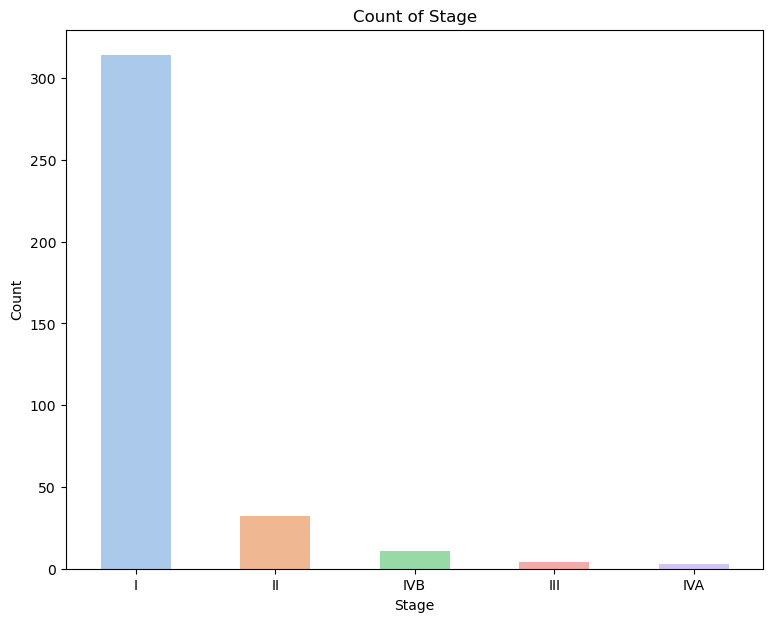

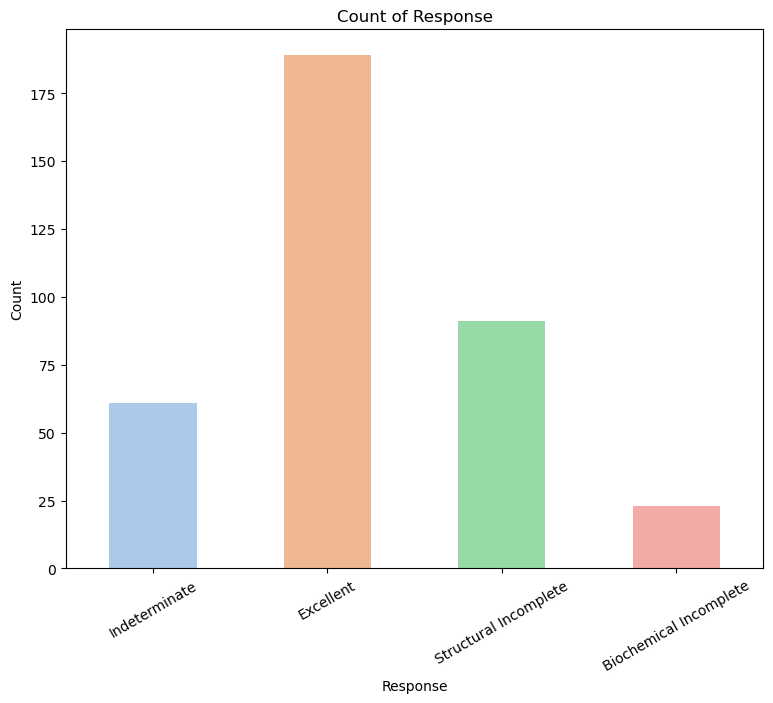

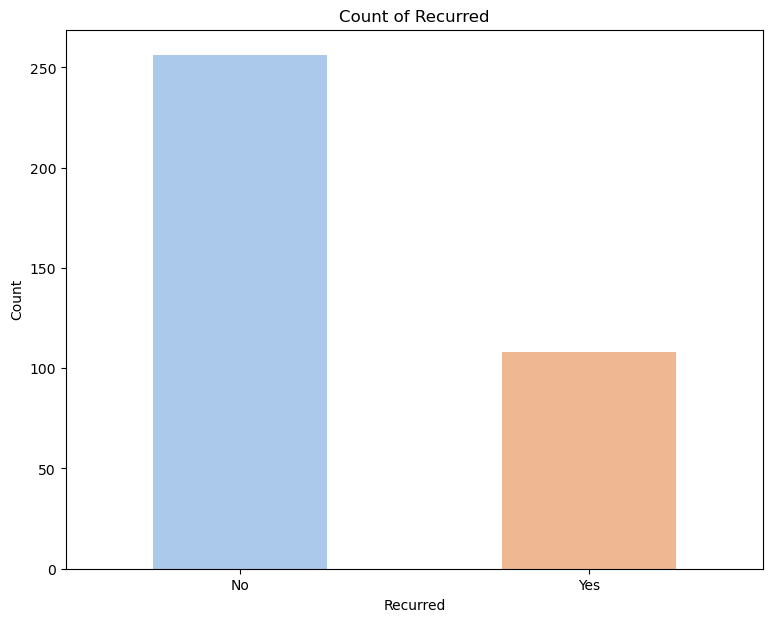

In [310]:
plot_data_graph('Age')
plot_data_graph('Gender')
plot_data_graph('Smoking')
plot_data_graph('Hx Smoking')
plot_data_graph('Hx Radiothreapy')
plot_data_graph('Thyroid Function')
plot_data_graph('Physical Examination')
plot_data_graph('Adenopathy')
plot_data_graph('Pathology')
plot_data_graph('Focality')
plot_data_graph('Risk')
plot_data_graph('T')
plot_data_graph('N')
plot_data_graph('M')
plot_data_graph('Stage')
plot_data_graph('Response')
plot_data_graph('Recurred')


In [315]:
def plot_recurrence_data(data_label):
     plt.figure(figsize=(10, 6))
     sns.countplot(x=data_label, hue='Recurred', data=df, palette='Blues')

     if ((df[data_label].astype(str).apply(len) > 15).any()):
         plt.xticks(rotation=30)
         
     plt.title(f'Recurrence Count for Each {data_label}', fontsize=16, weight='bold')
     plt.xlabel(data_label, fontsize=14)
     plt.ylabel('Count', fontsize=14)
     plt.legend(title='Recurred', title_fontsize='12', fontsize='10')


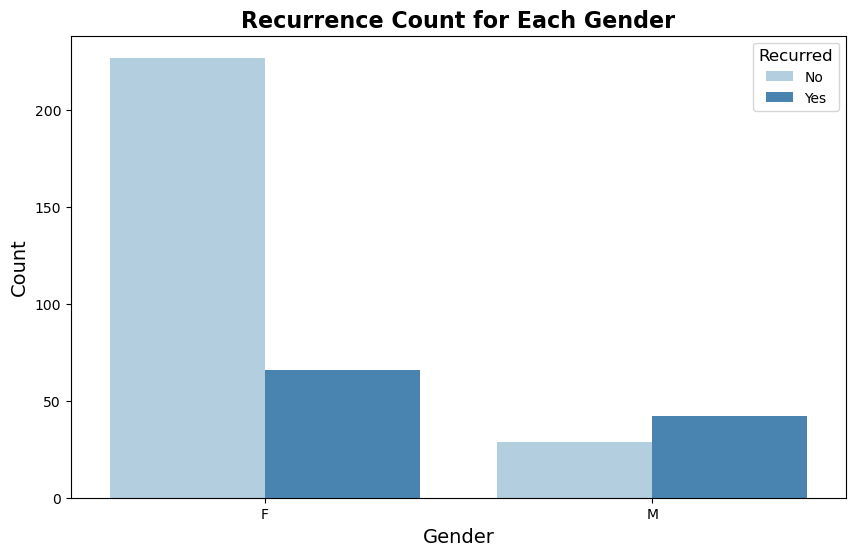

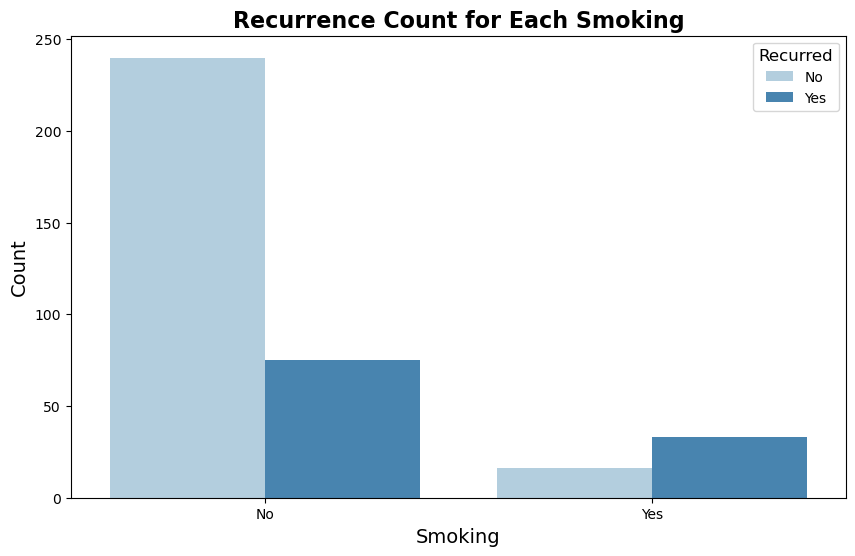

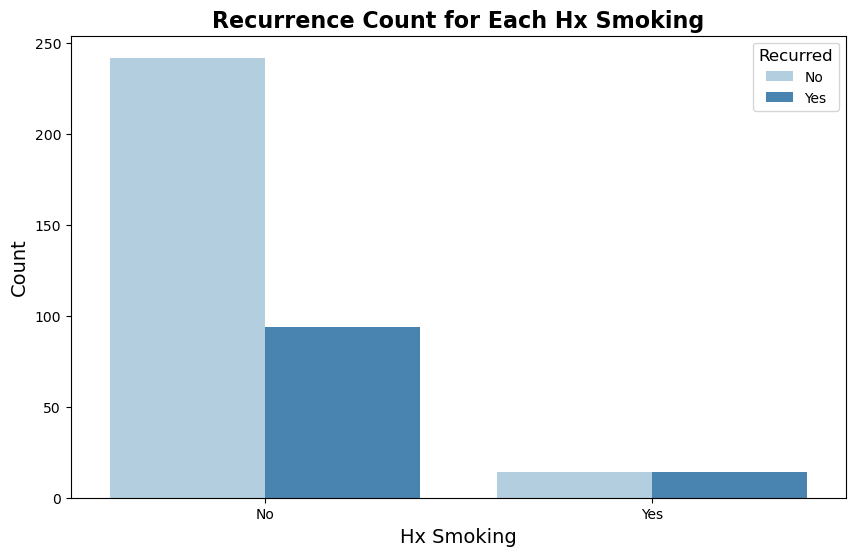

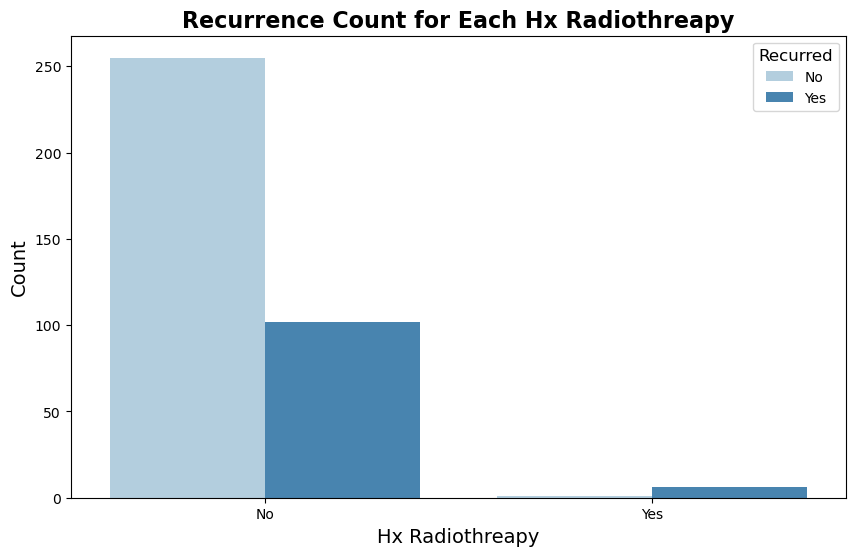

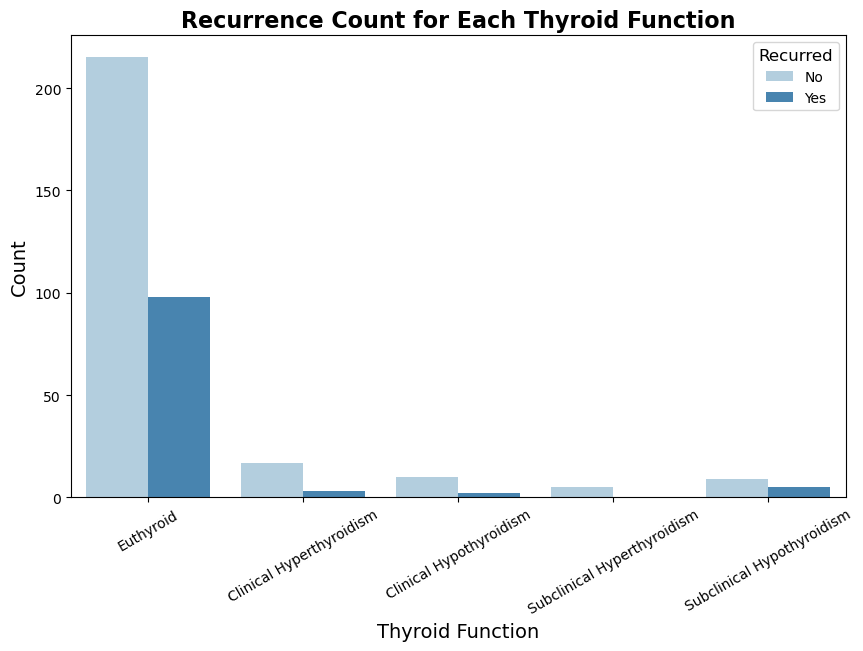

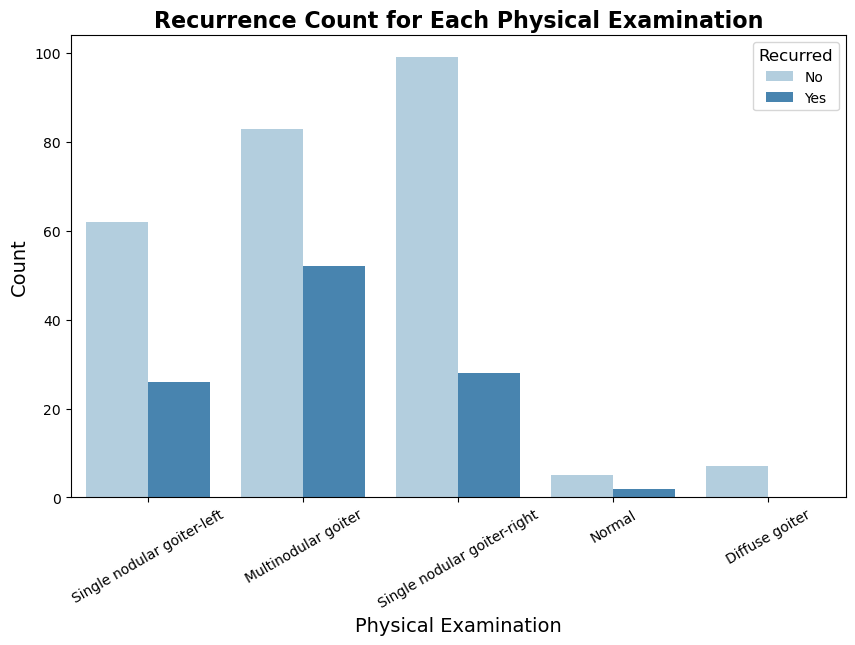

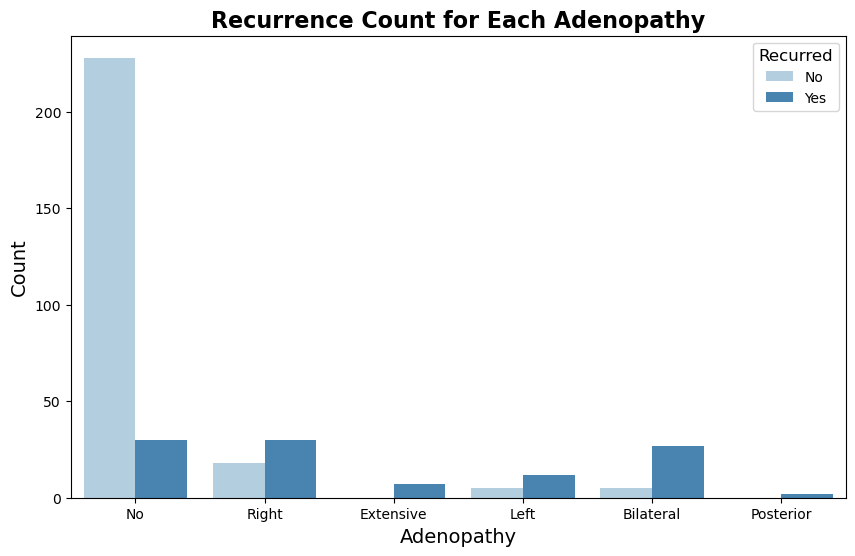

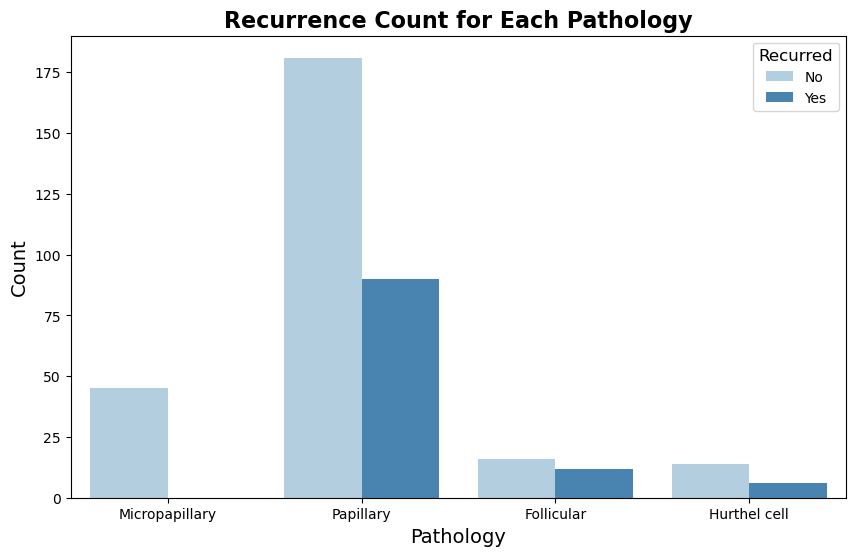

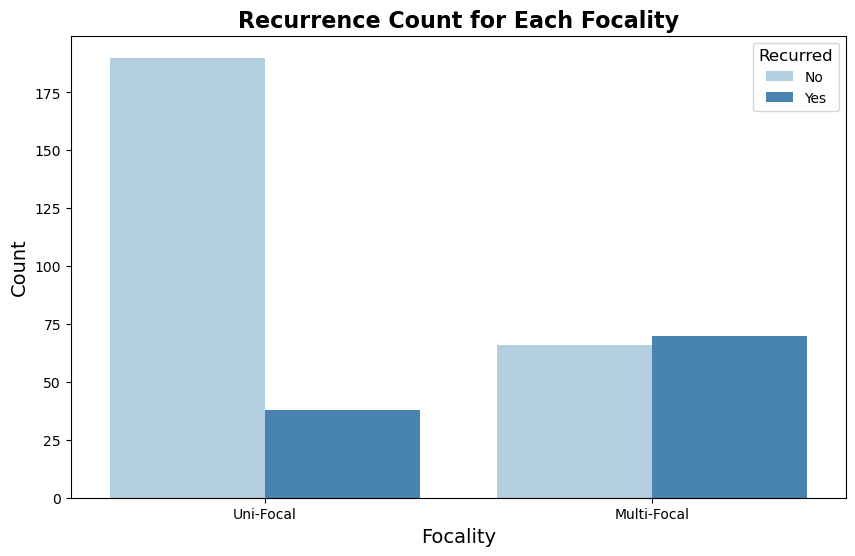

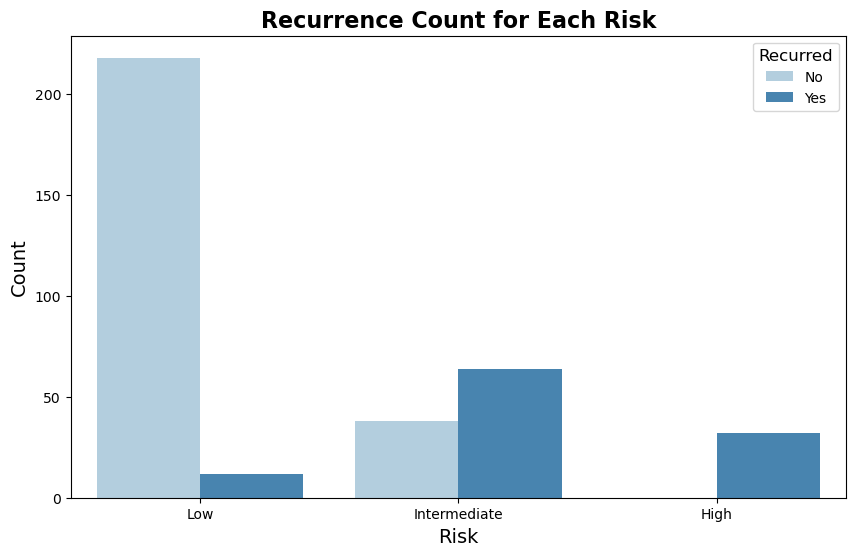

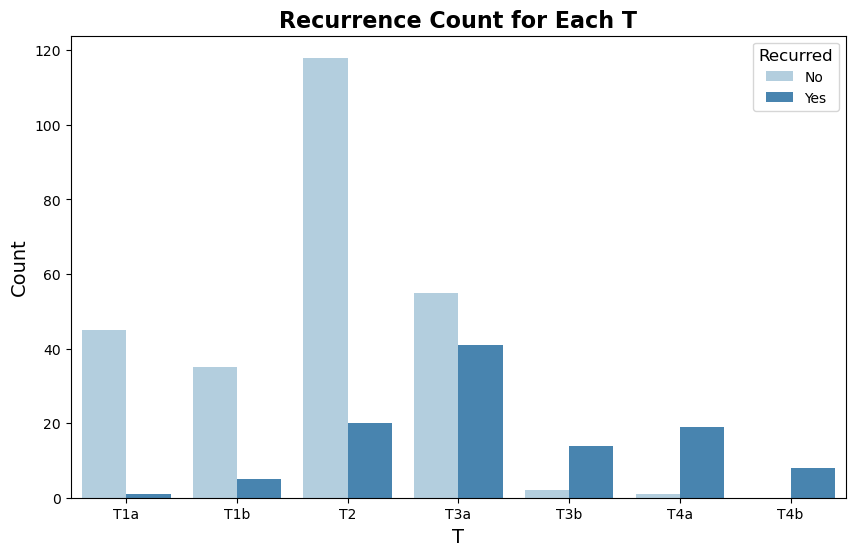

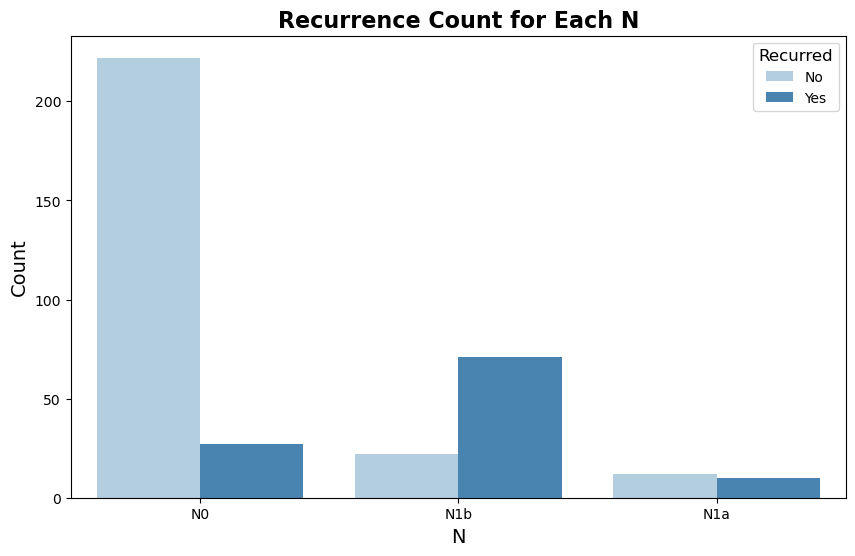

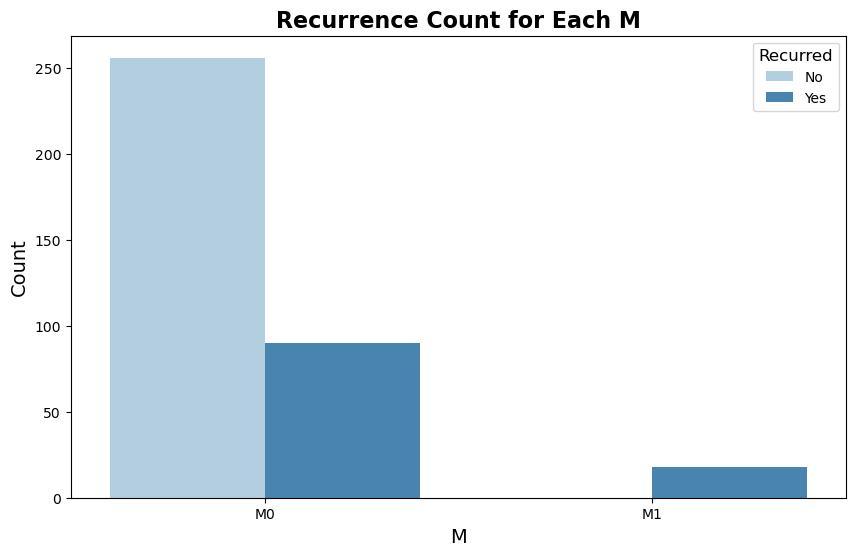

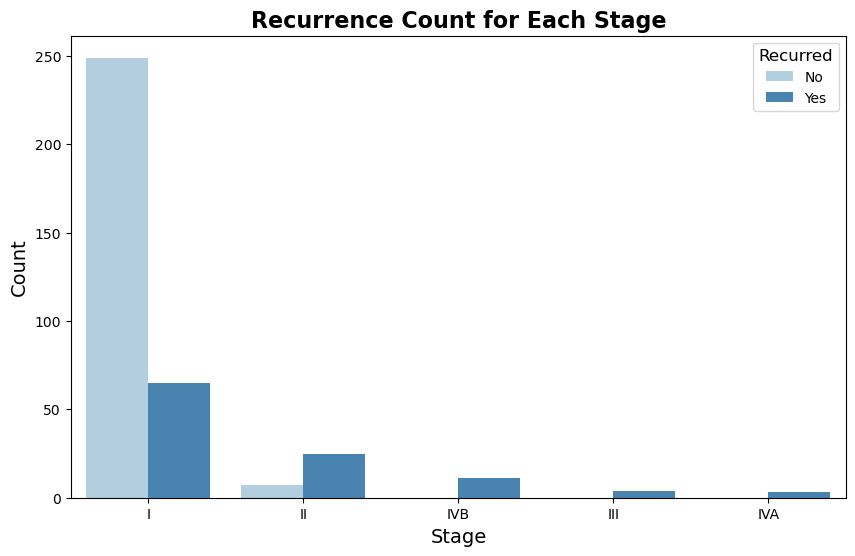

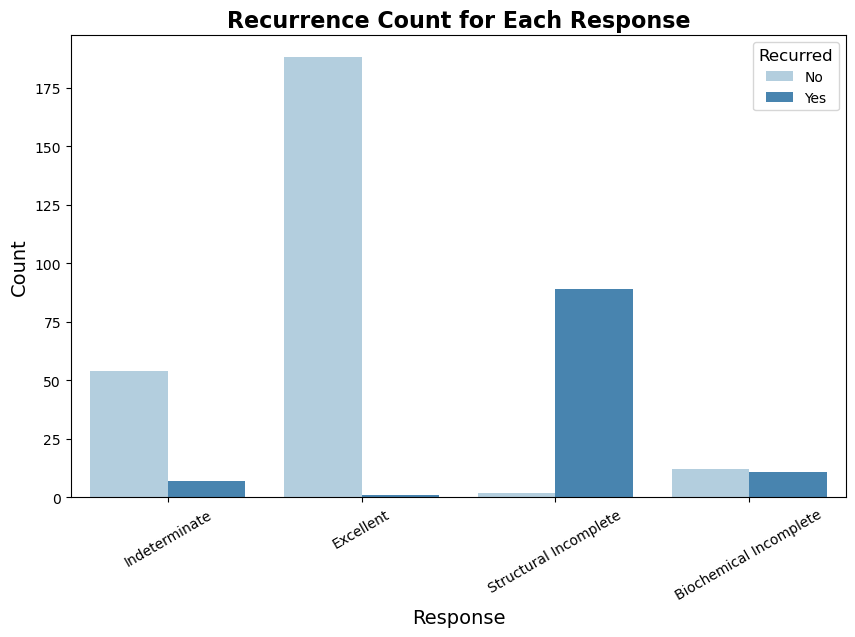

In [316]:
plot_recurrence_data('Gender')
plot_recurrence_data('Smoking')
plot_recurrence_data('Hx Smoking')
plot_recurrence_data('Hx Radiothreapy')
plot_recurrence_data('Thyroid Function')
plot_recurrence_data('Physical Examination')
plot_recurrence_data('Adenopathy')
plot_recurrence_data('Pathology')
plot_recurrence_data('Focality')
plot_recurrence_data('Risk')
plot_recurrence_data('T')
plot_recurrence_data('N')
plot_recurrence_data('M')
plot_recurrence_data('Stage')
plot_recurrence_data('Response')


In [10]:
df = df.drop_duplicates()


In [11]:
df.shape


(364, 17)

In [540]:
transformer = ColumnTransformer(
     transformers= [
          ('catagorical', OneHotEncoder(drop='first', handle_unknown='ignore'), ['Gender','Thyroid Function','Physical Examination','Adenopathy','Pathology']),
          ('ordinal', OrdinalEncoder(categories=[['No', 'Yes'], ['No', 'Yes'], ['No', 'Yes'],['Uni-Focal','Multi-Focal'], ['Low','Intermediate','High'], ['T1a', 'T1b', 'T2', 'T3a', 'T3b', 'T4a', 'T4b'],
                                                 ['N0','N1a','N1b'], ['M0','M1'],['I', 'II', 'IVB', 'III', 'IVA'], ['Excellent', 'Indeterminate', 'Biochemical Incomplete','Structural Incomplete']]),
                                                 ['Smoking','Hx Smoking','Hx Radiothreapy','Focality','Risk','T','N','M','Stage','Response']),
                                                 ('numeric', StandardScaler(), ['Age'])
     ],
     remainder='passthrough'
)


In [13]:
X = df.drop("Recurred",axis=1)


In [14]:
y = df['Recurred'].map({"No": 0 , "Yes":1})


In [542]:
X_transformed = transformer.fit_transform(X)


In [543]:
transformed_feature_names = transformer.get_feature_names_out(input_features=X.columns)
print(transformed_feature_names)


['catagorical__Gender_M'
 'catagorical__Thyroid Function_Clinical Hypothyroidism'
 'catagorical__Thyroid Function_Euthyroid'
 'catagorical__Thyroid Function_Subclinical Hyperthyroidism'
 'catagorical__Thyroid Function_Subclinical Hypothyroidism'
 'catagorical__Physical Examination_Multinodular goiter'
 'catagorical__Physical Examination_Normal'
 'catagorical__Physical Examination_Single nodular goiter-left'
 'catagorical__Physical Examination_Single nodular goiter-right'
 'catagorical__Adenopathy_Extensive' 'catagorical__Adenopathy_Left'
 'catagorical__Adenopathy_No' 'catagorical__Adenopathy_Posterior'
 'catagorical__Adenopathy_Right' 'catagorical__Pathology_Hurthel cell'
 'catagorical__Pathology_Micropapillary'
 'catagorical__Pathology_Papillary' 'ordinal__Smoking'
 'ordinal__Hx Smoking' 'ordinal__Hx Radiothreapy' 'ordinal__Focality'
 'ordinal__Risk' 'ordinal__T' 'ordinal__N' 'ordinal__M' 'ordinal__Stage'
 'ordinal__Response' 'numeric__Age']


In [544]:
transformed_df = pd.DataFrame(data=X_transformed,columns=transformer.get_feature_names_out())
transformed_df['Recurred'] = y
transformed_df.head()


catagorical__Gender_M  \
0                    0.0   
1                    0.0   
2                    0.0   
3                    0.0   
4                    0.0   

   catagorical__Thyroid Function_Clinical Hypothyroidism  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   catagorical__Thyroid Function_Euthyroid  \
0                                      1.0   
1                                      1.0   
2                                      1.0   
3                                      1.0   
4                                      1.0   

   catagorical__Thyroid Function_Subclinical Hyperthyroidism  \
0                                                0.0           
1                                                0.0           
2                                                0.0           
3                                                0.0           
4                                                0.0           

   catagorical__Thyroid Function_Subclinical Hypothyroidism  \
0                                                0.0          
1                                                0.0          
2                                                0.0          
3                                                0.0          
4                                                0.0          

   catagorical__Physical Examination_Multinodular goiter  \
0                                                0.0       
1                                                1.0       
2                                                0.0       
3                                                0.0       
4                                                1.0       

   catagorical__Physical Examination_Normal  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   catagorical__Physical Examination_Single nodular goiter-left  \
0                                                1.0              
1                                                0.0              
2                                                0.0              
3                                                0.0              
4                                                0.0              

   catagorical__Physical Examination_Single nodular goiter-right  \
0                                                0.0               
1                                                0.0               
2                                                1.0               
3                                                1.0               
4                                                0.0               

   catagorical__Adenopathy_Extensive  ...  ordinal__Hx Radiothreapy  \
0                                0.0  ...                       0.0   
1                                0.0  ...                       0.0   
2                                0.0  ...                       0.0   
3                                0.0  ...                       0.0   
4                                0.0  ...                       0.0   

   ordinal__Focality  ordinal__Risk  ordinal__T  ordinal__N  ordinal__M  \
0                0.0            0.0         0.0         0.0         0.0   
1                0.0            0.0         0.0         0.0         0.0   
2                0.0            0.0         0.0         0.0         0.0   
3                0.0            0.0         0.0         0.0         0.0   
4                1.0            0.0         0.0         0.0         0.0   

   ordinal__Stage  ordinal__Response  numeric__Age  Recurred  
0             0.0                1.

In [545]:
X_train,X_test,y_train,y_test = train_test_split(X_transformed,y,test_size=0.30,random_state=1)


In [410]:
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5,random_state=1)


# Model Train

In [470]:
def evaluate_model (true, pred):
    print("Model Evaluation: \n")
    accuracy = accuracy_score(true, pred)
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    roc = roc_auc_score(true, pred)
    f1 = f1_score(true, pred)
    print("Accuracy of the model is: %.2f"%(accuracy * 100) , "%")
    print("Precision of the model is: %.2f" %(precision * 100) , "%")
    print("Recall of the model is: %.2f" %(recall * 100) , "%")
    print("AUC value of the model is: %.2f" %(roc * 100) , "%")
    print("F1 score of the model is: %.2f" %(f1 * 100) , "%")


In [471]:
labels = ['norecurreance', 'recurreance']
def plot_cm(y_true, y_pred):
     print("\nConfusion Matrix: \n")
     cm = confusion_matrix(y_true, y_pred)
     plt.figure(figsize=(10,8))
     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
     plt.xlabel('Predicted Label', labelpad=20, fontsize=14)
     plt.ylabel('Truth Label', labelpad=20, fontsize=14)
     plt.show()


In [463]:
scaler = StandardScaler()


In [548]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [ ]:
X_val_scaled = scaler.transform(X_val)


In [466]:
dt = DecisionTreeClassifier()


In [476]:
dt.fit(X_train_scaled,y_train)


DecisionTreeClassifier()

In [477]:
y_pred_dt = dt.predict(X_test_scaled)


Model Evaluation: 

Accuracy of the model is: 93.64 %
Precision of the model is: 94.12 %
Recall of the model is: 86.49 %
AUC value of the model is: 91.87 %
F1 score of the model is: 90.14 %

Classification Report: 

               precision    recall  f1-score   support

           0       0.93      0.97      0.95        73
           1       0.94      0.86      0.90        37

    accuracy                           0.94       110
   macro avg       0.94      0.92      0.93       110
weighted avg       0.94      0.94      0.94       110


Confusion Matrix: 



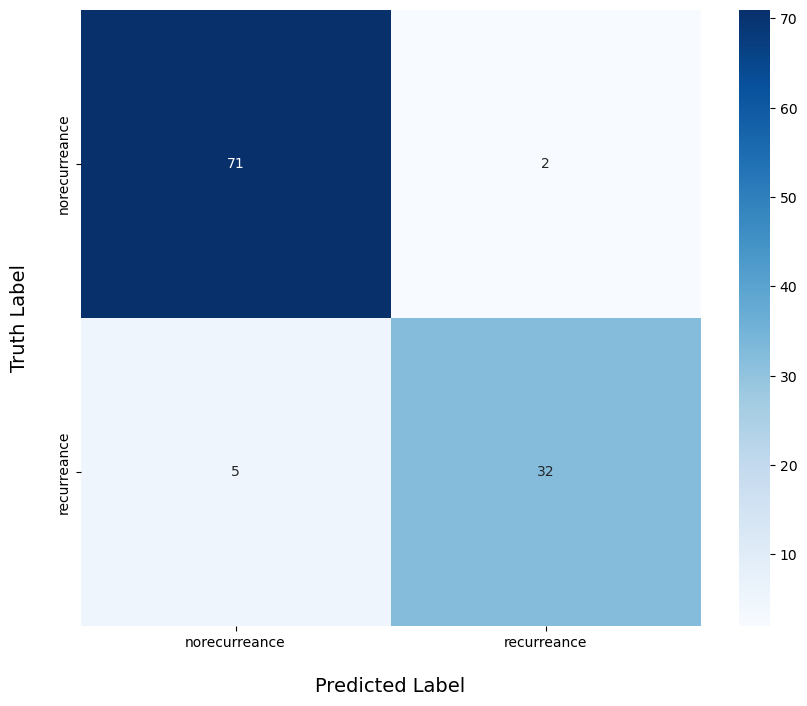

In [478]:
evaluate_model(y_test,y_pred_dt)
print("\nClassification Report: \n\n",classification_report(y_test,y_pred_dt))
plot_cm(y_test, y_pred_dt)


In [106]:
output_path = '../output/models'


In [107]:
# save model
def save_model(output_path, model_name, model):
    n = 1
    n=+1
    with open(f'{output_path}/{model_name}_{n}.pkl', 'wb') as file:
        pickle.dump(dt, file)



In [114]:
# load model
def load_model(model_path):
    with open(model_path, 'rb') as file:
        loaded_model = pickle.load(file)
        return loaded_model


In [115]:

load_dt_model = load_model('../output/models/decision_tree_model_0.pkl')
predictions = load_dt_model.predict(X_test_scaled)




In [479]:
def draw_decision_tree(decision_tree, feature_names=None, class_names=None):
    plt.figure(figsize=(50, 25))
    plot_tree(decision_tree, feature_names=feature_names, class_names=class_names, filled=True)
    plt.show()


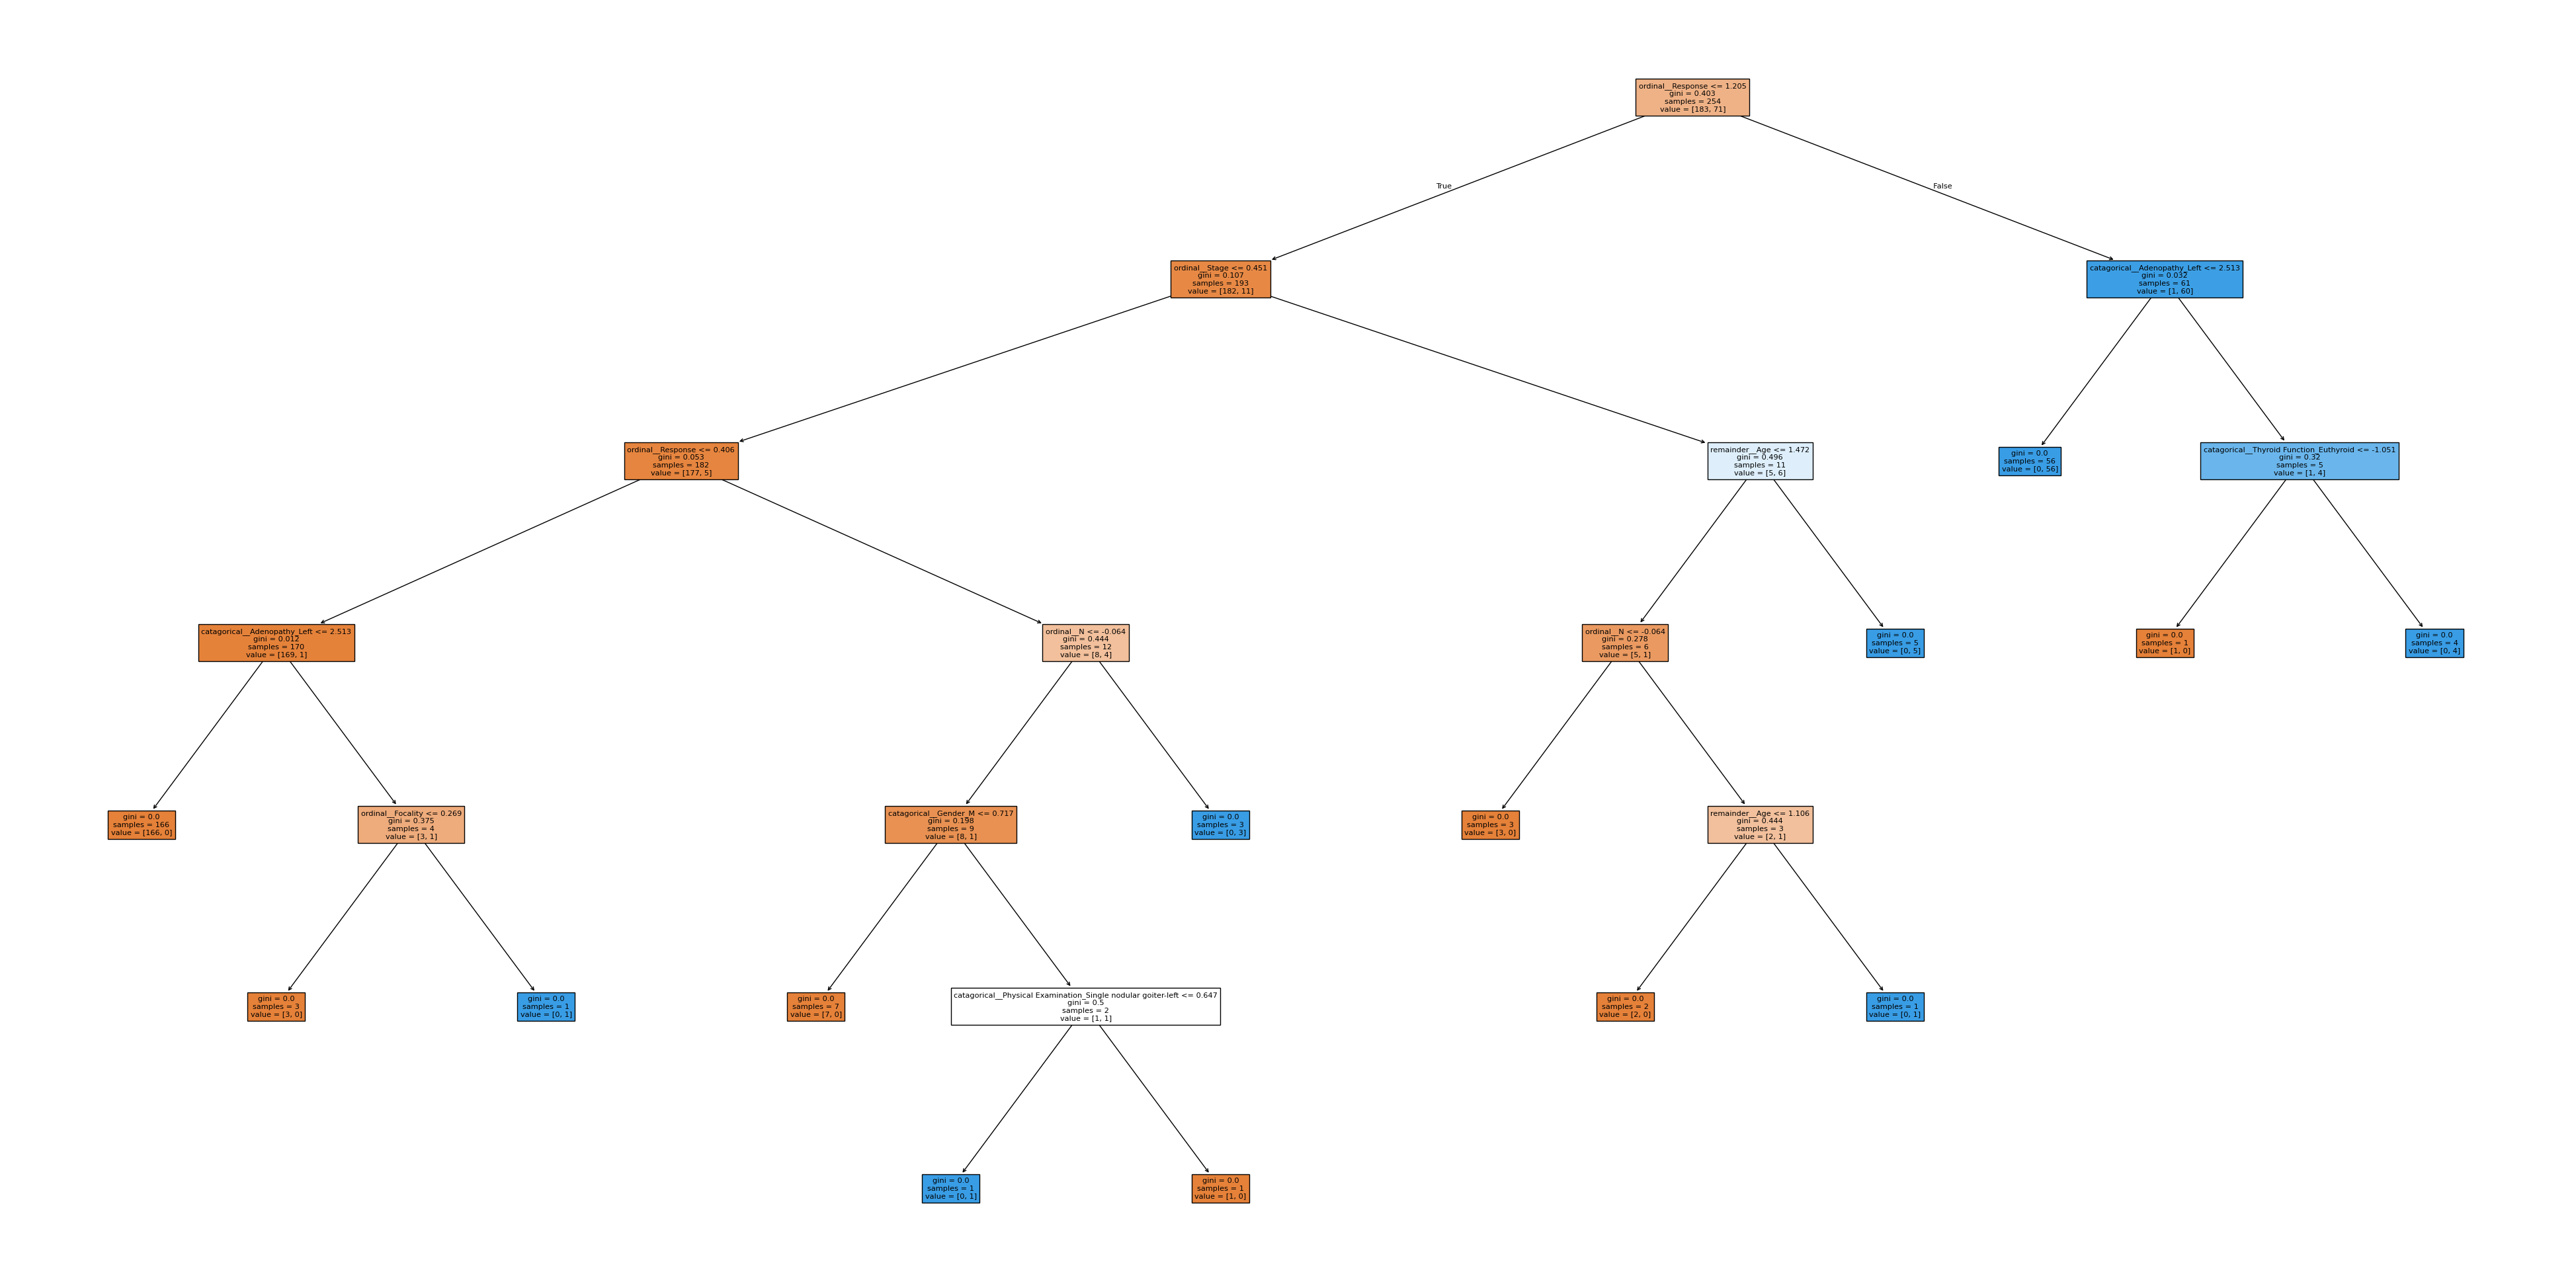

In [480]:
feature_names = [str(name) for name in transformed_feature_names]
draw_decision_tree(dt, feature_names=feature_names)


- train for knn, logistic regression like decision tree

In [546]:
rf = RandomForestClassifier()


In [549]:
rf.fit(X_train_scaled, y_train) 


RandomForestClassifier()

Model Evaluation: 

Accuracy of the model is: 95.45 %
Precision of the model is: 97.06 %
Recall of the model is: 89.19 %
AUC value of the model is: 93.91 %
F1 score of the model is: 92.96 %

Classification Report: 

               precision    recall  f1-score   support

           0       0.95      0.99      0.97        73
           1       0.97      0.89      0.93        37

    accuracy                           0.95       110
   macro avg       0.96      0.94      0.95       110
weighted avg       0.96      0.95      0.95       110


Confusion Matrix: 



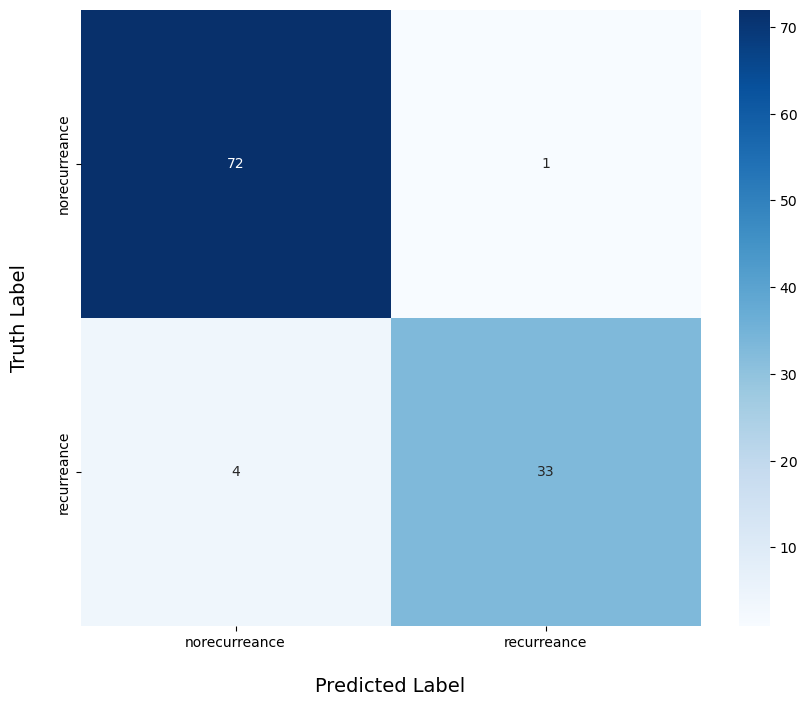

In [550]:
y_pred_rf = rf.predict(X_test_scaled)
evaluate_model(y_test,y_pred_rf)
print("\nClassification Report: \n\n",classification_report(y_test, y_pred_rf))
plot_cm(y_test, y_pred_rf)


In [450]:
def find_best_params(model, param_grid, n_jobs=-1, cv=5, scoring='recall'):
     grid = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
     best_params = grid.fit(X_val_scaled, y_val)
     print(f"Best recall for {model}: {grid.best_score_:.4f} with params: {grid.best_params_}")
     return best_params


In [451]:
rf_param_grid = {
    'n_estimators': [100, 300, 500, 1000],      
    'criterion' : ['gini','entropy','log_loss']  , 
    'max_depth': [None, 10, 30, 50, 100],                  
    'max_features': ['sqrt', 'log2'],        
    'bootstrap': [True, False],             
    'class_weight': [None, 'balanced']       
}


In [486]:
rf1 = RandomForestClassifier()


In [ ]:
rf_best_params = find_best_params(rf1, rf_param_grid)


Best recall for RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_features='log2', min_samples_leaf=4,
                       n_estimators=300): 0.8667 with params: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}


In [487]:
rf1.set_params(bootstrap= True,
  class_weight= 'balanced',
  criterion= 'gini',
  max_depth= None,
  max_features= 'sqrt',
  n_estimators= 100)


RandomForestClassifier(class_weight='balanced')

In [488]:
rf1.fit(X_train_scaled,y_train)


RandomForestClassifier(class_weight='balanced')

Model Evaluation: 

Accuracy of the model is: 95.45 %
Precision of the model is: 97.06 %
Recall of the model is: 89.19 %
AUC value of the model is: 93.91 %
F1 score of the model is: 92.96 %

Classification Report: 

               precision    recall  f1-score   support

           0       0.95      0.99      0.97        73
           1       0.97      0.89      0.93        37

    accuracy                           0.95       110
   macro avg       0.96      0.94      0.95       110
weighted avg       0.96      0.95      0.95       110


Confusion Matrix: 



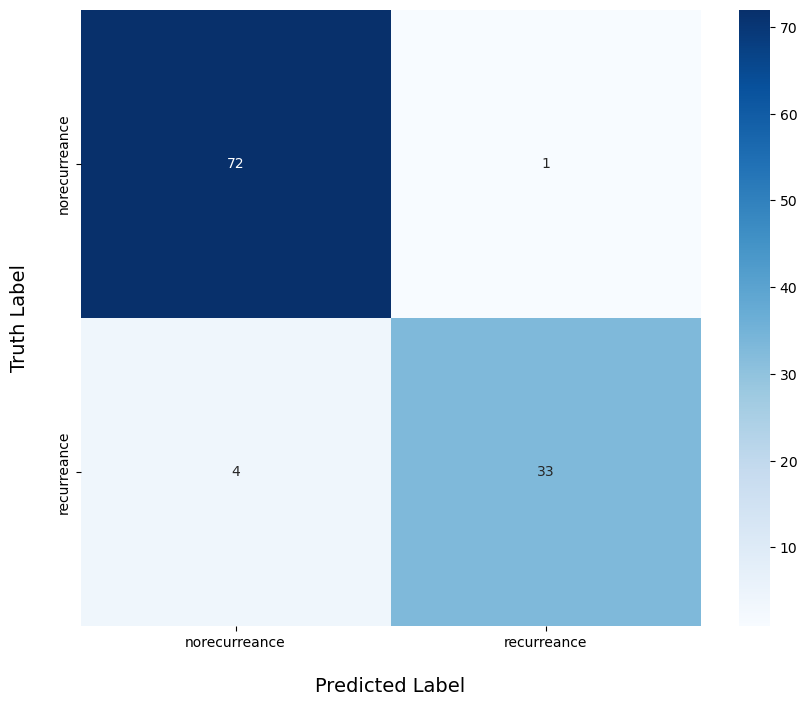

In [510]:
y_pred_rf1 = rf1.predict(X_test_scaled)
evaluate_model(y_test,y_pred_rf1)
print("\nClassification Report: \n\n",classification_report(y_test, y_pred_rf1))
plot_cm(y_test, y_pred_rf1)



- train for svm, adaboost with hyperparameter tuning like random forest

In [500]:
def kf_train(model, X, y, transformer, scaler, n_split=5):
     kf = KFold(n_splits=n_split, shuffle=True, random_state=42)

     avg = []

     for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
          X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
          y_train, y_test = y.iloc[train_index], y.iloc[test_index]

          X_train_transformed = transformer.fit_transform(X_train)
          X_test_transformed = transformer.transform(X_test)
          X_train_scaled = scaler.fit_transform(X_train_transformed)
          X_test_scaled = scaler.transform(X_test_transformed)

          model.fit(X_train_scaled, y_train)
          preds = model.predict(X_test_scaled)
          acc = accuracy_score(y_test, preds)
          avg.append(acc)
     
          print(f"Fold {fold + 1}: Accuracy score: {acc:.2f}")

     print(f"Average accuracy score : {sum(avg)/len(avg):.2f}")
     return acc


In [511]:
kf_train(rf, X, y, transformer, scaler, n_split=5)


Fold 1: Accuracy score: 0.96
Fold 2: Accuracy score: 0.97
Fold 3: Accuracy score: 0.97
Fold 4: Accuracy score: 0.96
Fold 5: Accuracy score: 0.97
Average accuracy score : 0.97


0.9722222222222222

- k-fold for all the models

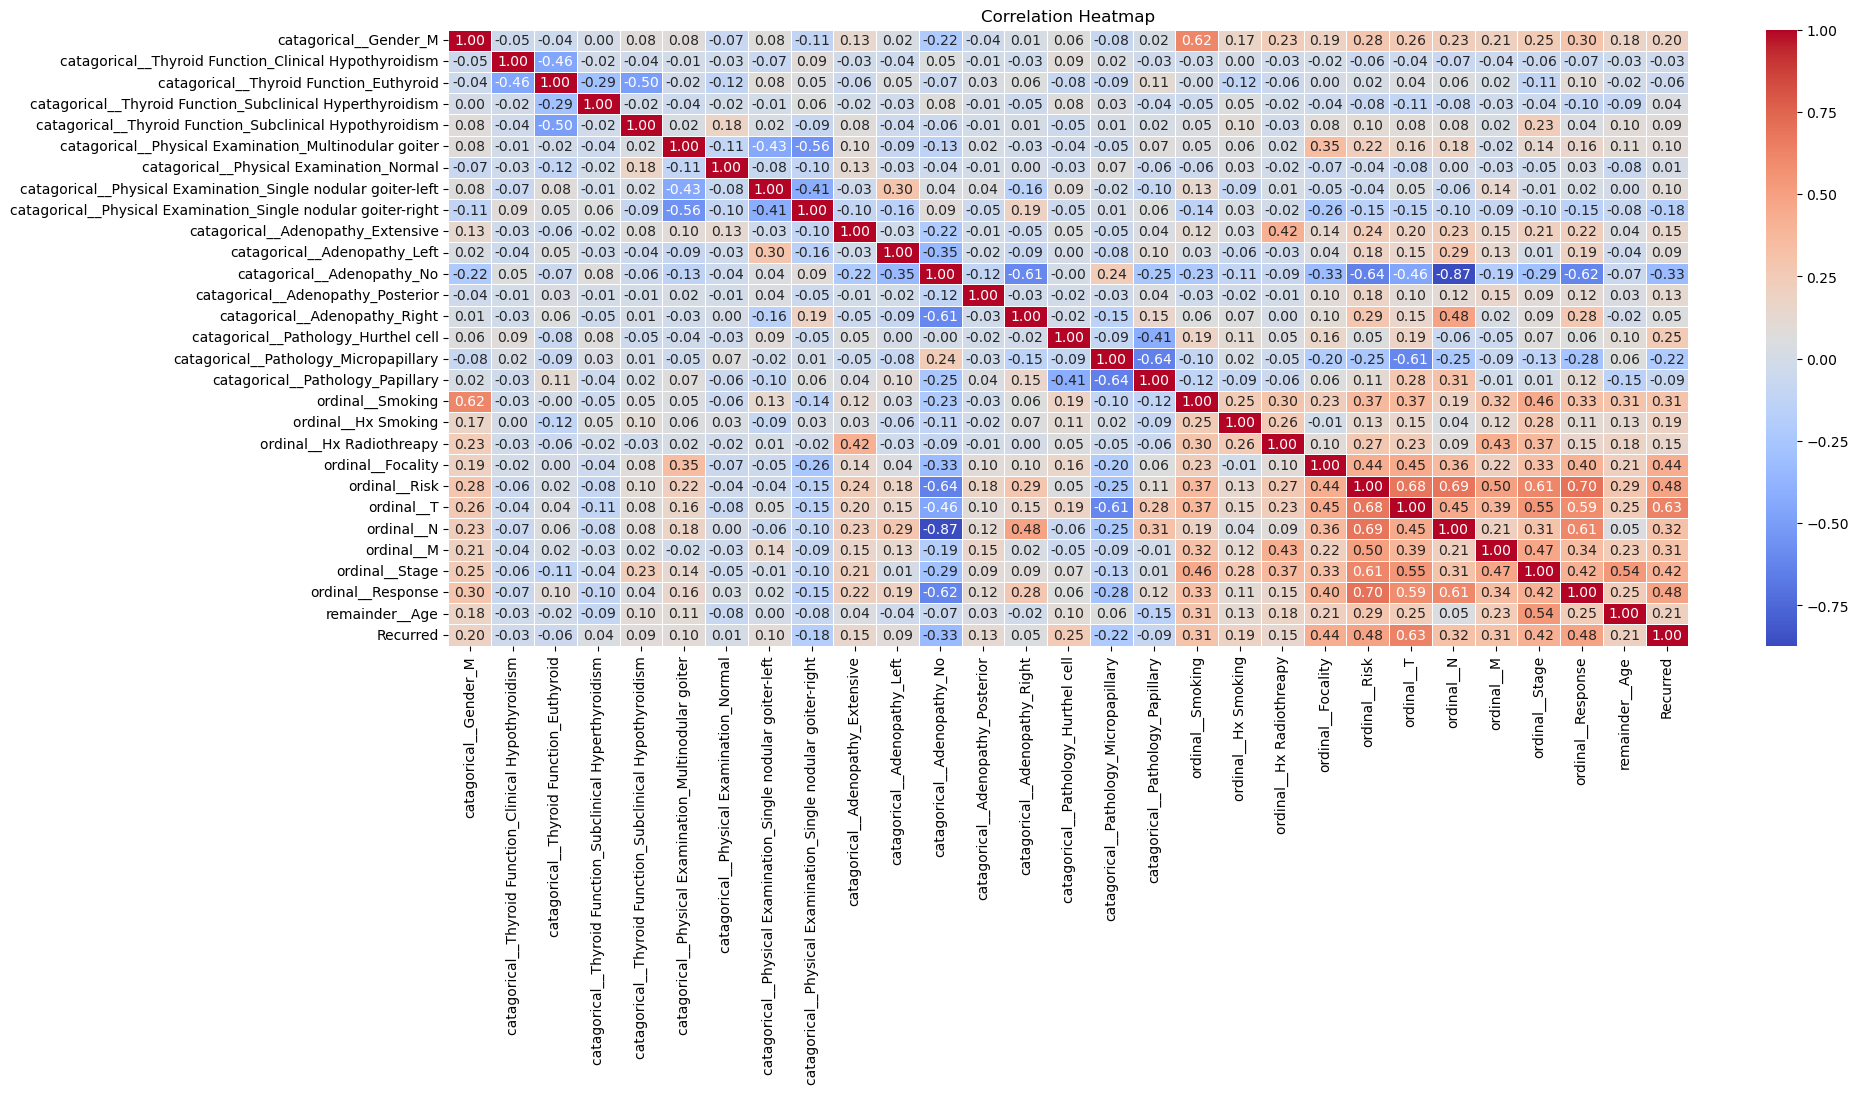

In [502]:
corr_matrix = transformed_df.corr()

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()


### Feature importance

In [629]:
feature_names_tf_df = transformed_df.drop('Recurred',axis=1).columns
feature_names = transformer.get_feature_names_out()


In [563]:
def plot_important_feature(model):
     feature_importances = model.feature_importances_

     features_df = pd.DataFrame({'Feature': feature_names_tf_df, 'Importance': feature_importances})

     features_df = features_df.sort_values(by='Importance', ascending=False)

     plt.figure(figsize=(50, 25))
     plt.barh(features_df['Feature'], features_df['Importance'])
     plt.xlabel('Importance')
     plt.title('Random Forest Feature Importances')
     plt.show()


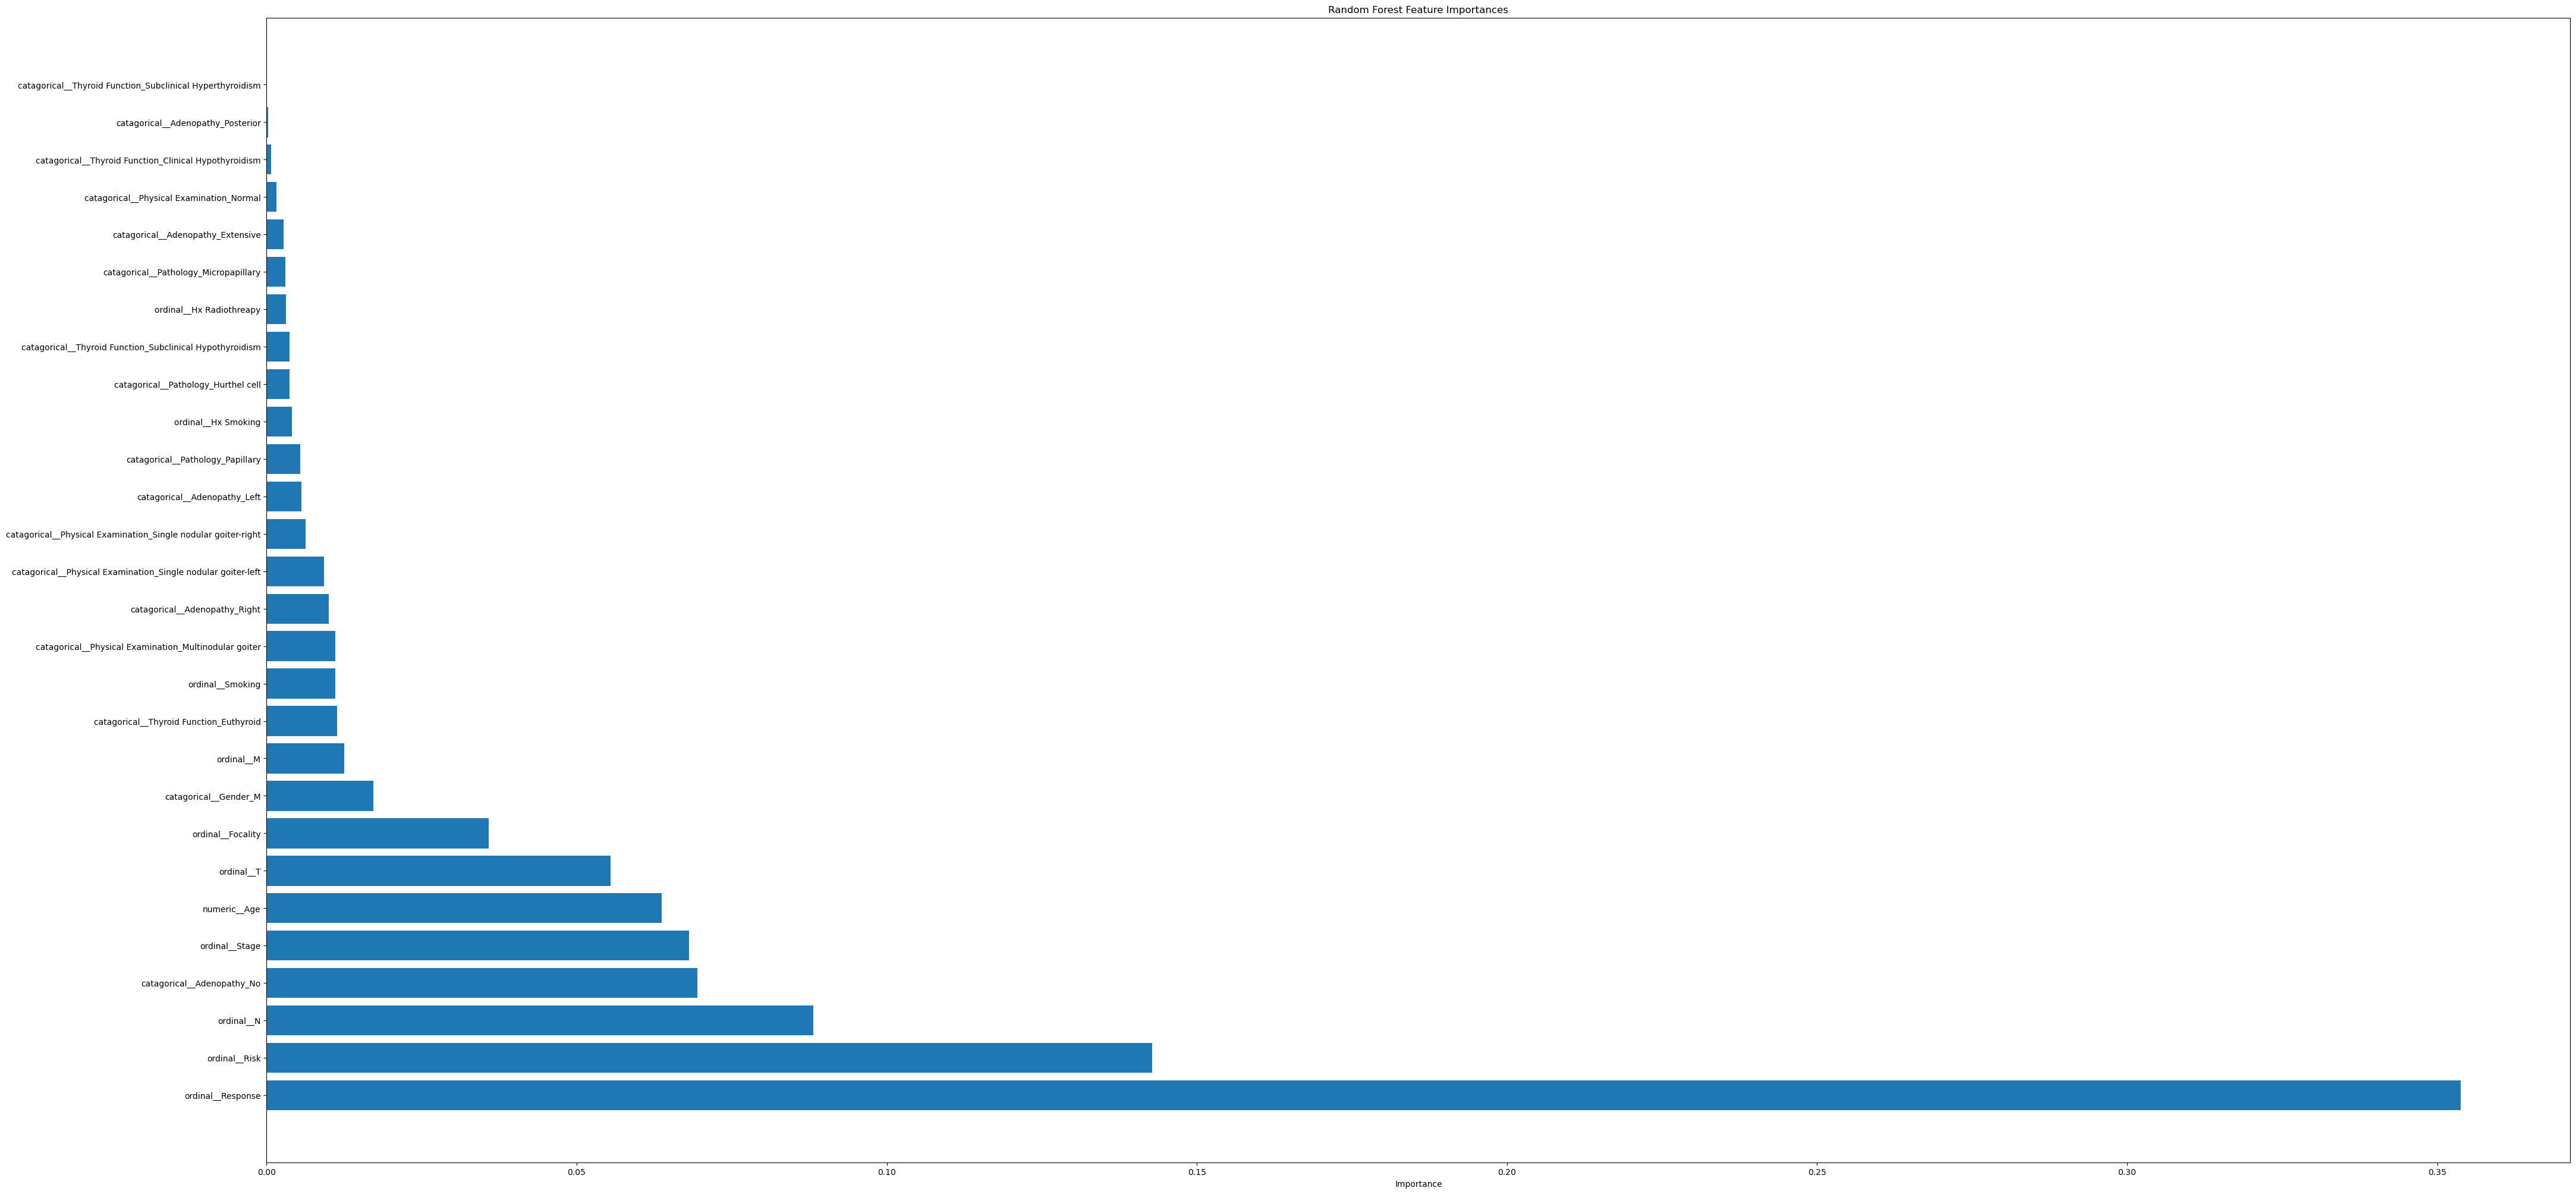

In [564]:
plot_important_feature(rf)


- imp features for other models

## XAI using LIME 

In [569]:
X.columns


Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response'],
      dtype='object')

In [571]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    mode='classification',
    feature_names=transformer.get_feature_names_out(),
    class_names=['Not Recurred', 'Recurred'], 
    discretize_continuous=True
)


In [630]:
def exp_lime(model):
    exp = explainer.explain_instance(
        X_test_scaled[11], 
        model.predict_proba,   
        num_features=len(feature_names)
    )
    exp.show_in_notebook(show_table=True)
    return exp


In [631]:
def plot_exp(exp):
    feature_importances = exp.as_list()

    features, importances = zip(*feature_importances)

    colors = sns.color_palette("pastel")

    plt.figure(figsize=(10, 8))
    plt.barh(features, importances, color=colors)

    plt.xlabel('Importance')
    plt.title('LIME Feature Importance')

    plt.grid(False)
    plt.show()


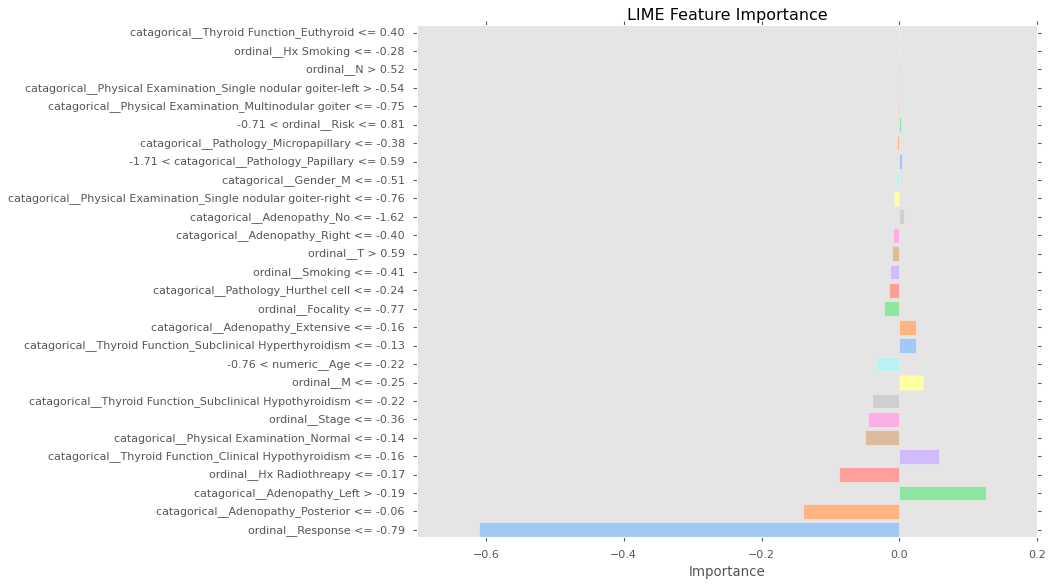

In [632]:
plot_exp(exp_lime(dt))


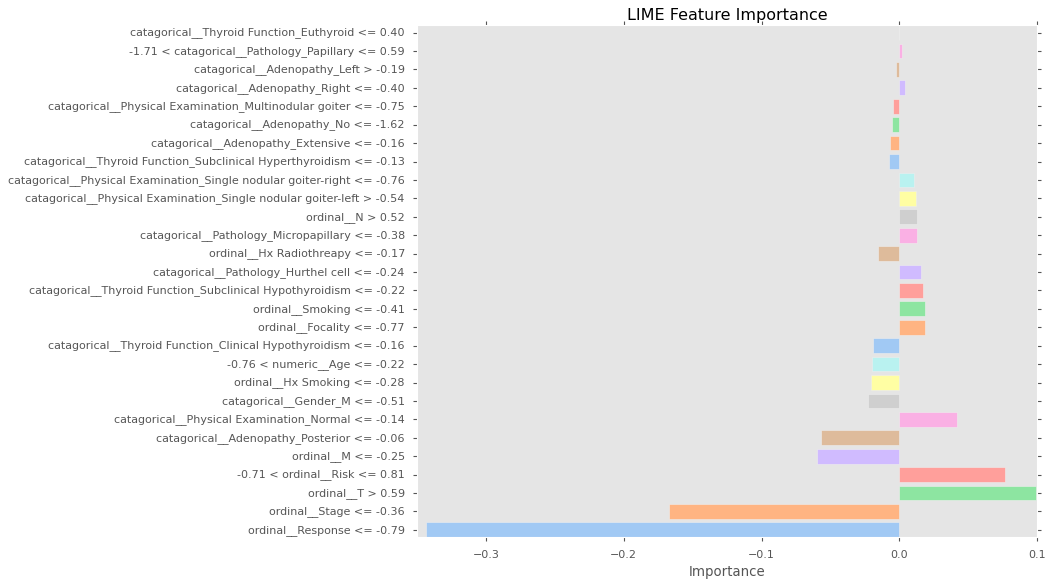

In [633]:
plot_exp(exp_lime(rf))


- for all other models